In [1]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pickle

from sklearn.ensemble import RandomForestClassifier
from sklearn.calibration import CalibratedClassifierCV
from sklearn.model_selection import train_test_split
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier

# from tqdm.notebook import tqdm
from joblib import Parallel, delayed

import time
start_time = time.time()

In [2]:
def generate_data(n, mean, var):
    y = 2 * np.random.binomial(1, .5, n) - 1 # classes are -1 and 1.
    X = np.random.multivariate_normal(mean * y, var * np.eye(n), 1).T
    return X, y

In [3]:
class UncertaintyForest:
    def __init__(self, n_estimators = 300, max_samples = .4, base = np.exp(1), kappa = 3):
        self.n_estimators = n_estimators
        self.max_samples = max_samples
        self.base = base
        self.kappa = kappa
        
    def fit(self, X, y):
        
        # Preprocess y.
        self.classes_, y = np.unique(y, return_inverse=True)
        
        # Build forest with default parameters.
        model = BaggingClassifier(DecisionTreeClassifier(), 
                                  n_estimators=self.n_estimators, 
                                  max_samples=self.max_samples, 
                                  bootstrap=False)
        model.fit(X, y)
        n = X.shape[0]
        K = model.n_classes_
        
        self.posteriors = []
        for tree_idx, tree in enumerate(model):

            # Find the indices of the training set used for partition.
            sampled_indices = model.estimators_samples_[tree_idx]
            vote_indices = np.delete(np.arange(0,n), sampled_indices)

            # Store the posterior in a num_nodes-by-num_classes matrix.
            # Posteriors in non-leaf cells will be zero everywhere
            # and later changed to uniform.
            node_counts = tree.tree_.n_node_samples
            class_counts = np.zeros((len(node_counts), K))
            for vote_index in vote_indices:
                class_counts[tree.apply(X[vote_index].reshape(1, -1)).item(), y[vote_index]] += 1
            row_sums = class_counts.sum(axis=1) # Total number of estimation points in each leaf.
            row_sums[row_sums == 0] = 1 # Avoid divide by zero.
            class_probs = class_counts / row_sums[:, None]

            # Make the nodes that have no estimation indices uniform.
            # This includes non-leaf nodes, but that will not affect the estimate.
            where_empty = np.argwhere(class_probs.sum(axis = 1) == 0)
            for elem in where_empty:
                class_probs[elem] = [1 / K]*K

            # Apply finite sample correction and renormalize.
            where_0 = np.argwhere(class_probs == 0)
            for elem in where_0:
                class_probs[elem[0], elem[1]] = 1 / (self.kappa*class_counts.sum(axis = 1)[elem[0]])
            row_sums = class_probs.sum(axis=1)
            class_probs = class_probs / row_sums[:, None]
            self.posteriors.append(class_probs)
            
        self.model = model
        return self
            
    def predict_proba(self, X):
    
        n = X.shape[0]
        K = self.model.n_classes_
        eval_posteriors = np.zeros((n, K))
        
        for tree_idx, tree in enumerate(self.model):
            # Place evaluation points in their corresponding leaf node.
            # Store evaluation posterior in a num_eval-by-num_class matrix.
            class_probs = self.posteriors[tree_idx]
            eval_posteriors += np.array([class_probs[x] for x in tree.apply(X)])

        return eval_posteriors / self.n_estimators

In [4]:
# Estimate posteriors for many trials and evaluate in the given X_eval range.
def estimate_posterior(algo, n, mean, var, num_trials, X_eval, parallel = False):
    obj = algo['instance']
    def worker(t):
        X, y = generate_data(n, mean, var)
        obj.fit(X, y)
        class_1_index = np.argwhere(obj.classes_.ravel() == 1)[0][0]
        return obj.predict_proba(X_eval)[:, class_1_index]
        
    if parallel:
        predicted_posterior = np.array(Parallel(n_jobs=-2)(delayed(worker)(t) for t in range(num_trials)))
    else:
        predicted_posterior = np.zeros((num_trials, X_eval.shape[0]))
        for t in tqdm(range(num_trials)):
            predicted_posterior[t, :] = worker(t)

    return predicted_posterior

In [5]:
# For either a CART, Honest, or Uncertainty Forest, plot P(Y = 1 | X = x).
def plot_posterior(ax, algo, num_plotted_trials, X_eval):
    # Plot each of num_plotted_trials iterations, highlighting a single line.
    for i in range(num_plotted_trials):
        linewidth = 1
        opacity = .3
        if i == num_plotted_trials - 1:
            opacity = 1
            linewidth = 8
        ax.set_title(algo['title'])
        ax.plot(X_eval.flatten().ravel(), algo['predicted_posterior'][i, :].ravel(), 
                label = algo['label'],
                linewidth = linewidth, 
                color = algo['color'], 
                alpha = opacity)

# Plot the variance over the number of trials.
def plot_variance(ax, algos, X_eval):
    ax.set_title('Posterior Variance')
    for algo in algos:
        variance = np.var(algo['predicted_posterior'], axis = 0)
        ax.plot(X_eval.flatten().ravel(), variance.ravel(), 
                label = algo['label'],
                linewidth = 8, 
                color = algo['color'])

In [6]:
# Communal plotting parameters.
def plot_fig1(algos, num_plotted_trials):
    sns.set(font_scale = 6)
    sns.set_style("ticks")
    plt.rcParams['figure.figsize'] = [55, 14]
    fig, axes = plt.subplots(1, 4)
    for ax in axes[0:3]:
        ax.set_xlim(-2.1, 2.1)
        ax.set_ylim(-0.05, 1.05)

    # 3 posterior plots.
    for i in range(len(algos)):
        plot_posterior(axes[i], 
                       algos[i],
                       num_plotted_trials, 
                       X_eval)

    # 1 variance plot.
    # axes[3].set_ylim(-0.05, 0.1)
    plot_variance(axes[3], algos, X_eval)
    
    fig.text(0.5, .08, 'x', ha='center')
    axes[0].set_ylabel(r"$\hat P(Y = 1|X = x)$")
    axes[0].set_xlabel(" ")
    axes[3].set_ylabel(r"Var($\hat P(Y = 1|X = x)$)")
    
    fig.tight_layout()
    plt.savefig("fig1_siam.pdf")
    plt.show()

In [ ]:
# Communal plotting parameters.
def plot_fig1_modified(algos, num_plotted_trials):
    sns.set(font_scale = 6)
    sns.set_style("ticks")
    plt.rcParams['figure.figsize'] = [28, 28]
    fig, axes = plt.subplots(2, 2)
    for ax in axes[0,:]:
        ax.set_xlim(-2.1, 2.1)
        ax.set_ylim(-0.05, 1.05)
    for ax in axes[1,:]:
        ax.set_xlim(-2.1, 2.1)
        ax.set_ylim(-0.05, 1.05)

    # 3 posterior plots.
    plot_posterior(axes[0,0], 
                       algos[0],
                       num_plotted_trials, 
                       X_eval)
    plot_posterior(axes[0,1], 
                       algos[1],
                       num_plotted_trials, 
                       X_eval)
    plot_posterior(axes[1,0], 
                       algos[2],
                       num_plotted_trials, 
                       X_eval)


    # 1 variance plot.
    # axes[3].set_ylim(-0.05, 0.1)
    plot_variance(axes[1,1], algos, X_eval)
    
    fig.text(0.5, .08, 'x', ha='center')
    axes[0,0].set_ylabel(r"$\hat P(Y = 1|X = x)$")
    axes[0,0].set_xlabel(" ")
    axes[1,1].set_ylabel(r"Var($\hat P(Y = 1|X = x)$)")
    
    fig.tight_layout()
    plt.savefig("fig1_siam_2x2.pdf")
    plt.show()

In [7]:
# Real Params.
n = 6000
mean = 1
var = 1
num_trials = 100
X_eval = np.linspace(-2, 2, num = 30).reshape(-1, 1)
n_estimators = 300
num_plotted_trials = 10

# Test Params.
# n = 300
# mean = 1
# var = 1
# num_trials = 3
# X_eval = np.linspace(-2, 2, num = 10).reshape(-1, 1)
# n_estimators = 200
# num_plotted_trials = 2

# Algorithms.
algos = [
    {
        'instance': RandomForestClassifier(n_estimators = n_estimators),
        'label': 'CART',
        'title': 'CART Forest',
        'color': "#1b9e77",
    },
    {
        'instance': CalibratedClassifierCV(base_estimator=RandomForestClassifier(n_estimators = n_estimators // 5), 
                                           method='isotonic', 
                                           cv = 5),
        'label': 'IRF',
        'title': 'Isotonic Reg. Forest',
        'color': "#fdae61",
    },
    {
        'instance': UncertaintyForest(n_estimators = n_estimators),
        'label': 'UF',
        'title': 'Uncertainty Forest',
        'color': "#F41711",
    },
]

# Plotting parameters.
parallel = True

In [ ]:
# Generate data and predictions.
for algo in algos:
    algo['predicted_posterior'] = estimate_posterior(algo, n, mean, var, num_trials, X_eval, parallel = parallel)
    
with open('algos_fig1_siam.pkl', 'wb') as f:
    pickle.dump(algos, f)

In [ ]:
with open('algos_fig1_siam.pkl', 'rb') as f:
    algos = pickle.load(f)
    
plot_fig1(algos, num_plotted_trials)


In [ ]:
plot_fig1_modified(algos, num_plotted_trials)

In [ ]:
print("--- %s seconds ---" % (time.time() - start_time))

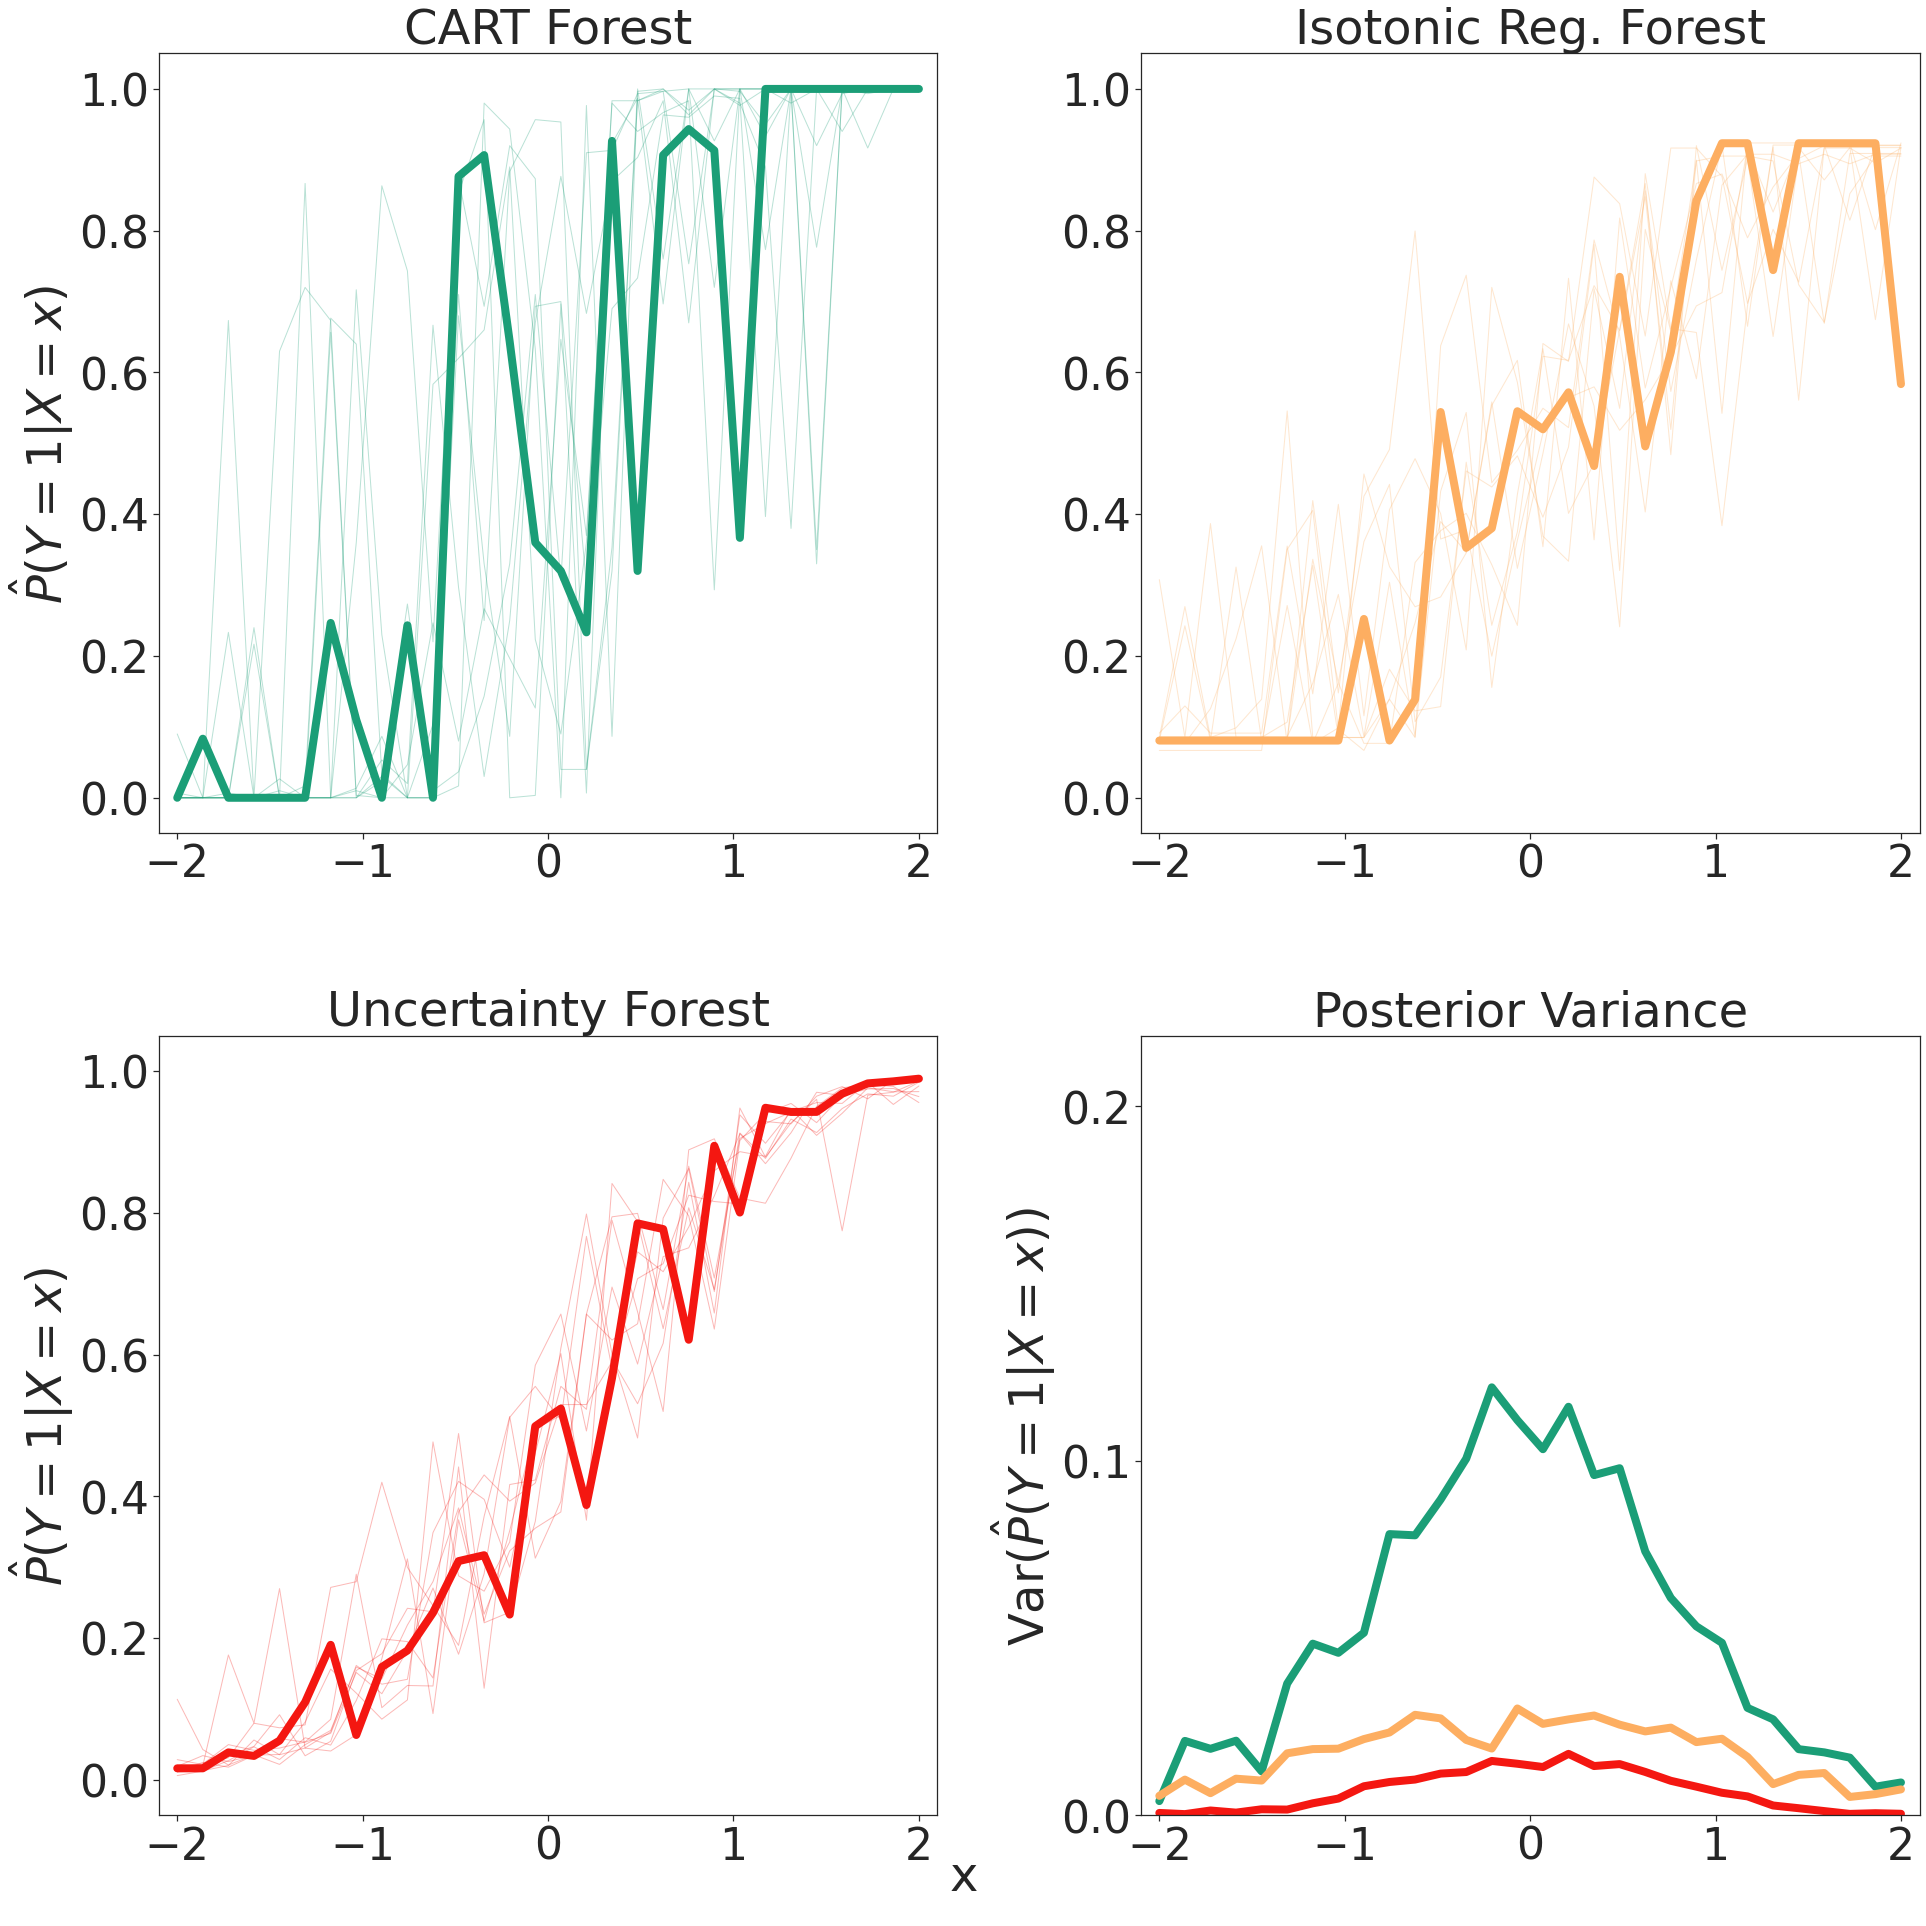

In [9]:
with open('algos_fig1.pkl', 'rb') as f:
    algos = pickle.load(f)

from matplotlib.ticker import FormatStrFormatter

# Communal plotting parameters.
def plot_fig1_modified2(algos, num_plotted_trials):
    sns.set(font_scale = 4)
    sns.set_style("ticks")
    plt.rcParams['figure.figsize'] = [28, 28]
    fig, axes = plt.subplots(2, 2)
    for ax in axes[0,:]:
        ax.set_xlim(-2.1, 2.1)
        ax.set_ylim(-0.05, 1.05)
    for ax in axes[1,:]:
        ax.set_xlim(-2.1, 2.1)
        ax.set_ylim(-0.05, 1.05)
    axes[0,0].yaxis.set_major_formatter(FormatStrFormatter('%.1f'))
    axes[0,1].yaxis.set_major_formatter(FormatStrFormatter('%.1f'))
    axes[1,0].yaxis.set_major_formatter(FormatStrFormatter('%.1f'))
    axes[1,1].yaxis.set_major_formatter(FormatStrFormatter('%.1f'))

    axes[0,0].yaxis.set_ticks(np.arange(0.0, 1.05, 0.2))
    axes[0,1].yaxis.set_ticks(np.arange(0.0, 1.05, 0.2))
    axes[1,0].yaxis.set_ticks(np.arange(0.0, 1.05, 0.2))

    # 3 posterior plots.
    plot_posterior(axes[0,0], 
                       algos[0],
                       num_plotted_trials, 
                       X_eval)
    plot_posterior(axes[0,1], 
                       algos[1],
                       num_plotted_trials, 
                       X_eval)
    plot_posterior(axes[1,0], 
                       algos[2],
                       num_plotted_trials, 
                       X_eval)


    # 1 variance plot.
    axes[1,1].set_ylim(0.0, 0.22)
    axes[1,1].yaxis.set_ticks(np.arange(0.0, 0.22, 0.1))
    plot_variance(axes[1,1], algos, X_eval)
    
    fig.text(0.5, .04, 'x', ha='center')
    axes[0,0].set_ylabel(r"$\hat P(Y = 1|X = x)$")
    axes[0,0].set_xlabel(" ")
    axes[1,0].set_ylabel(r"$\hat P(Y = 1|X = x)$")
    axes[1,0].set_xlabel(" ")
    axes[1,1].set_ylabel(r"Var($\hat P(Y = 1|X = x)$)")
    
    fig.tight_layout()
    plt.savefig("fig1_siam_2x2_fulldata.pdf")
    plt.show()
    
plot_fig1_modified2(algos, num_plotted_trials)